In [1]:
import os
import math
import time
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from skimage import io
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import matplotlib.pyplot as plt
from modelsummary import summary
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TrainingDataset(Dataset):
    def __init__(self, data_dir, transform,in_memory=False):      
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames]
        self.transform = transform
        self.in_memory = in_memory
        self.data_dir = data_dir
        self.inputs = []
        self.outputs = []
        if(self.in_memory):
            self.loadimages()
      
    def __len__(self):
        #size of dataset
        return len(self.filenames)
      
    def __getitem__(self, idx):
        if(self.in_memory):
            input_image = self.inputs[idx]
            output_image = self.outputs[idx]
        else:
            image = io.imread(self.filenames[idx]) 
            input_image, output_image = self.preprocess(image)
        return input_image, output_image
    
    def loadimages(self):
        for file in self.filenames:
            input_,output_ = self.preprocess(io.imread(file))
            self.inputs.append(input_)
            self.outputs.append(output_)
        return
        
    
    def preprocess(self, image):
        # standardize and convert image to Labspace
        # return X(Lightness) and Y(ab) tuple 
        image = np.array(image, dtype=float)
        image = 1.0/255*image
        image = rgb2lab(image)
        image = (image + [0, 128, 128]) / [100, 255, 255]
        output_image = image[:,:,1:]
        input_image = image[:,:,0]
        input_image = input_image.reshape((input_image.shape[0],input_image.shape[1],1))
        input_image = self.transform(input_image)
        output_image = self.transform(output_image)
        input_image.permute(2,1,0)  
        output_image.permute(2,1,0)
        return input_image, output_image
        
        

In [4]:
#Directory containing images for training
train_data_path = 'mixed/'

#Specify input_image_dim expects square only
input_image_dim = 256

#Transformations needed on the input images
transformer = transforms.Compose([
  transforms.ToTensor()]) 

#Build dataset object
dataset = TrainingDataset(train_data_path, transformer, in_memory=True)
#Total samples
total_samples = len(dataset)

In [5]:
#Hyperparameters
n_epochs = 30
batch_size = 20
lr = 0.001
#Number of processes to load data
number_of_workers = 4

#Dev(validation) data as ratio of training data
validation_split = 0.1

#Get indices
indices = list(np.arange(len(dataset)))
#Compute validation and training sample sizes
validation_data_size = int(np.ceil(len(dataset)*validation_split))
training_data_size = total_samples - validation_data_size
#Random selection of 
random_seed = 33
np.random.seed(random_seed)
np.random.shuffle(indices)

#Split into training and validation dataloaders
train_sampler = SubsetRandomSampler(indices[validation_data_size:])
train_dataloader = DataLoader(dataset, 
                              batch_size=batch_size,  
                              num_workers=number_of_workers, sampler=train_sampler)

validation_sampler = SubsetRandomSampler(indices[:validation_data_size])
validation_dataloader = DataLoader(dataset, 
                              batch_size=batch_size, 
                              num_workers=number_of_workers, sampler=validation_sampler)

n_batches = len(train_dataloader)

In [6]:
def get_padding_for_same(input_size,kernel_size = 3,stride = 1):
    #To keep the input size the same the padding will be computed as
    padding = int((stride*(input_size - 1) - input_size + kernel_size)/2)
    
    return (padding, padding)  

In [7]:
def get_output_size(input_size, kernel_size = 3, stride = 1, padding = 0):
    #Output size after a layer
    output_size = int((input_size - kernel_size + 2*(padding)) / stride) + 1
    return(output_size)

In [8]:
#Find padding needed for keeping the output size the same
input_size = input_image_dim
same_padding_with_strides  = get_padding_for_same(input_size,stride=2)
same_padding_without_strides = get_padding_for_same(input_size)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(1,64, 3, padding = 1,stride=2)
        self.conv2 = nn.Conv2d(64,128, 3, padding = same_padding_without_strides)
        self.conv3 = nn.Conv2d(128,128, 3,  padding = 1, stride=2)
        self.conv4 = nn.Conv2d(128,256, 3, padding = same_padding_without_strides)
        self.conv5 = nn.Conv2d(256,256, 3,  padding = 1, stride=2)
       
        
        #Decoder
        self.conv6 = nn.Conv2d(256,128,3, padding = same_padding_without_strides)
        self.upsample1= nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(128,64,3,padding=same_padding_without_strides)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv8 = nn.Conv2d(64,32,3,padding=same_padding_without_strides)
        self.conv9 = nn.Conv2d(32,16,3,padding=same_padding_without_strides)
        self.conv10 = nn.Conv2d(16,2,3,padding=same_padding_without_strides)
        self.upsample3 = nn.Upsample(scale_factor=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.upsample1(x)
        x = F.relu(self.conv7(x))
        x = self.upsample2(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.upsample3(x)
        return x

torch.cuda.empty_cache()
model = Model().to(device)

In [10]:
summary(Model(), torch.zeros((1, 1, 256, 256)), show_input=False)

-----------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
                 Conv2d-1         [-1, 64, 128, 128]             640
                 Conv2d-2        [-1, 128, 128, 128]          73,856
                 Conv2d-3          [-1, 128, 64, 64]         147,584
                 Conv2d-4          [-1, 256, 64, 64]         295,168
                 Conv2d-5          [-1, 256, 32, 32]         590,080
                 Conv2d-6          [-1, 128, 32, 32]         295,040
               Upsample-7          [-1, 128, 64, 64]               0
                 Conv2d-8           [-1, 64, 64, 64]          73,792
               Upsample-9         [-1, 64, 128, 128]               0
                Conv2d-10         [-1, 32, 128, 128]          18,464
                Conv2d-11         [-1, 16, 128, 128]           4,624
                Conv2d-12          [-1, 2, 128, 128]             290
              Upsample-13      

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

In [12]:
print("Train on {} samples, validate on {} samples".format(training_data_size, validation_data_size))

training_start_time = time.time()
history = {}
training_losses = []
validation_losses = []

for epoch in range(n_epochs):  # loop over the dataset multiple times
    print("Epoch {}/{}".format(epoch+1, n_epochs))
    
    training_loss = 0.0
    start_time = time.time()
    samples_processed = 0
    progress_meter_constant = 100/training_data_size 
    progress_meter_constant /= 3.33
    for i, data in enumerate(train_dataloader,0):
        
        X, y = data
        
        # Transfer to GPU if available
        X, y = X.float(), y.float()
        X, y = X.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        #compute loss for history
        training_loss += loss.item()
           
        #metrics for displaying
        samples_processed += len(X)
        epoch_time = ""
        epoch_loss = ""
        
        if(samples_processed == training_data_size):
            epoch_time = " - " + str(int(time.time()-start_time))+'s'
            epoch_loss = " - loss: {0:10.5f}".format(training_loss/n_batches)
        progress_equals = math.ceil(progress_meter_constant*samples_processed)
        progress_spaces = 30 - progress_equals
        result_display = "{}/{}  [{}{}]".format(samples_processed, training_data_size,
                '='*progress_equals,' '*progress_spaces)+"{}".format(epoch_time)+"{}".format(epoch_loss)
        
        print(result_display,end='\r')
        
    training_losses.append(training_loss/n_batches)
    training_loss = 0.0
    
    #Conduct validation
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for dev_index, dev_data in enumerate(validation_dataloader):
            X_val, y_val = dev_data
            X_val, y_val = X_val.float(), y_val.float()
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            val_outputs = model(X_val)
            dev_loss = criterion(val_outputs, y_val)
            validation_loss += dev_loss.item()
        total_validation_loss = validation_loss/len(validation_dataloader)
        validation_losses.append(total_validation_loss)
    print(result_display + " - val_loss: {0:10.5f}".format(total_validation_loss),end='\r')
    model.train()
    print("")
            
        
print('Finished Training')
print("--- {0:10.5} seconds ---".format((time.time() - training_start_time)))

Train on 3137 samples, validate on 349 samples
Epoch 1/30
3137/3137  [===============================] - 61s - loss:    0.02644 - val_loss:    0.00283
Epoch 2/30
3137/3137  [===============================] - 62s - loss:    0.00280 - val_loss:    0.00255
Epoch 3/30
3137/3137  [===============================] - 64s - loss:    0.00259 - val_loss:    0.00283
Epoch 4/30
3137/3137  [===============================] - 65s - loss:    0.00269 - val_loss:    0.00245
Epoch 5/30
3137/3137  [===============================] - 65s - loss:    0.00256 - val_loss:    0.00243
Epoch 6/30
3137/3137  [===============================] - 66s - loss:    0.00266 - val_loss:    0.00249
Epoch 7/30
3137/3137  [===============================] - 65s - loss:    0.00255 - val_loss:    0.00243
Epoch 8/30
3137/3137  [===============================] - 65s - loss:    0.00249 - val_loss:    0.00243
Epoch 9/30
3137/3137  [===============================] - 67s - loss:    0.00256 - val_loss:    0.00236
Epoch 10/30
3137/

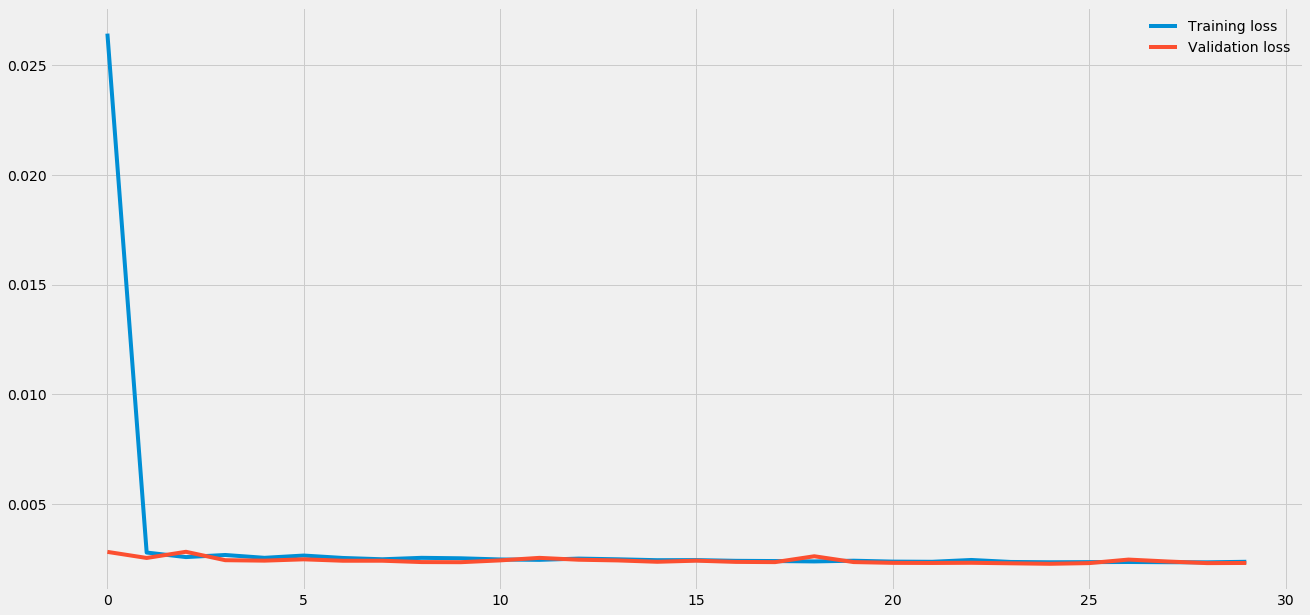

In [19]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(20,10))
    plt.plot(n_epochs, training_losses, label='Training loss')
    plt.plot(n_epochs, validation_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

In [14]:
def show_images(filename, predicted):
    original = io.imread(filename)
    grey = rgb2gray(original)
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(original)
    plt.subplot(132)
    plt.imshow(grey,cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted)

In [15]:
def predict_validation_colour_image(input_L):    
    L = input_L
    L = L.float()
    L = L.to(device)
    L = L.unsqueeze(0)
    ab = model(L).cpu()
    ab = ab.squeeze()
    ab = ab.permute(2,1,0)
    ab = ab.detach().numpy()
    coloured = np.zeros((input_image_dim,input_image_dim,3))
    coloured[:,:,0] = input_L.reshape((input_image_dim,input_image_dim))
    coloured[:,:,1:] = ab
    coloured = (coloured * [100, 255, 255]) - [0, 128, 128]
    rgb_image = lab2rgb(coloured)
    return rgb_image
    

In [16]:
#Display result of model on a batch of random validation images
indices = np.random.choice(validation_dataloader.batch_sampler.sampler.indices, size=5, replace=False)
files = [dataset.filenames[i] for i in indices]

In [ ]:
for i,index in enumerate(indices):
    L,ab = dataset.__getitem__(index)
    predicted = predict_validation_colour_image(L)
    show_images(files[i],predicted)